[ ] get initial data
    yolo script downloads https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels.zip
    Downloading http://images.cocodataset.org/zips/train2017.zip to /Users/maksimgaiduk/repos/datasets/coco/images/train2017.zip...
    Downloading http://images.cocodataset.org/zips/val2017.zip to /Users/maksimgaiduk/repos/datasets/coco/images/val2017.zip...
    Downloading http://images.cocodataset.org/zips/test2017.zip to /Users/maksimgaiduk/repos/datasets/coco/images/test2017.zip...
[ ] train dataset
[ ] train dataloader

In [85]:
coco_idx_to_label = {0 :"person",
1 :"bicycle",
2 :"car",
3 :"motorcycle",
4 :"airplane",
5 :"bus",
6 :"train",
7 :"truck",
8 :"boat",
9 :"traffic light",
10: "fire hydrant",
11: "stop sign",
12: "parking meter",
13: "bench",
14: "bird",
15: "cat",
16: "dog",
17: "horse",
18: "sheep",
19: "cow",
20: "elephant",
21: "bear",
22: "zebra",
23: "giraffe",
24: "backpack",
25: "umbrella",
26: "handbag",
27: "tie",
28: "suitcase",
29: "frisbee",
30: "skis",
31: "snowboard",
32: "sports ball",
33: "kite",
34: "baseball bat",
35: "baseball glove",
36: "skateboard",
37: "surfboard",
38: "tennis racket",
39: "bottle",
40: "wine glass",
41: "cup",
42: "fork",
43: "knife",
44: "spoon",
45: "bowl",
46: "banana",
47: "apple",
48: "sandwich",
49: "orange",
50: "broccoli",
51: "carrot",
52: "hot dog",
53: "pizza",
54: "donut",
55: "cake",
56: "chair",
57: "couch",
58: "potted plant",
59: "bed",
60: "dining table",
61: "toilet",
62: "tv",
63: "laptop",
64: "mouse",
65: "remote",
66: "keyboard",
67: "cell phone",
68: "microwave",
69: "oven",
70: "toaster",
71: "sink",
72: "refrigerator",
73: "book",
74: "clock",
75: "vase",
76: "scissors",
77: "teddy bear",
78: "hair drier",
79: "toothbrush",}

In [100]:
import hashlib
import torch
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, TQDM_BAR_FORMAT, check_amp, check_dataset, check_file, check_git_info,
                           check_git_status, check_img_size, check_requirements, check_suffix, check_yaml, colorstr,
                           get_latest_run, increment_path, init_seeds, intersect_dicts, labels_to_class_weights,
                           labels_to_image_weights, methods, one_cycle, print_args, print_mutation, strip_optimizer,
                           yaml_save)
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from multiprocessing.pool import Pool, ThreadPool
import os
from pathlib import Path
from itertools import repeat
import random
import torchvision
from utils.general import (DATASETS_DIR, LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, check_dataset, check_requirements,
                           check_yaml, clean_str, cv2, is_colab, is_kaggle, segments2boxes, unzip_file, xyn2xy,
                           xywh2xyxy, xywhn2xyxy, xyxy2xywhn)
from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste,
                                 letterbox, mixup, random_perspective)
import numpy as np

def show_image(image, label):
    boxes = torchvision.ops.box_convert(boxes=label[:,2:] * 640, in_fmt="cxcywh", out_fmt="xyxy")
    classes = []
    for obj in label:
        class_idx = int(obj[1].item())
        classes.append(coco_idx_to_label[class_idx])
    image = torchvision.utils.draw_bounding_boxes(image, boxes, labels=classes, colors="red", width=2, font_size=400)
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    #plt.title(f'Label: {label}')
    plt.show()



In [3]:
train_path = "/Users/maksimgaiduk/repos/datasets/coco/train2017.txt"
imgsz = 640
batch_size = 32
WORLD_SIZE = 1
gs = 32 # grid size, aka max stride
single_cls = False
hyp = {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.001, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
cache = None
rect = False # rectangular training
LOCAL_RANK = -1
workers = 8
image_weights = False
quad = False
seed = 0

In [5]:
HELP_URL = 'See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data'
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'  # include image suffixes

def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]

def verify_image_label(args):
    # Verify one image-label pair
    im_file, lb_file, prefix = args
    nm, nf, ne, nc, msg, segments = 0, 0, 0, 0, '', []  # number (missing, found, empty, corrupt), message, segments
    try:
        # verify images
        im = Image.open(im_file)
        im.verify()  # PIL verify
        shape = exif_size(im)  # image size
        assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
        assert im.format.lower() in IMG_FORMATS, f'invalid image format {im.format}'
        if im.format.lower() in ('jpg', 'jpeg'):
            with open(im_file, 'rb') as f:
                f.seek(-2, 2)
                if f.read() != b'\xff\xd9':  # corrupt JPEG
                    ImageOps.exif_transpose(Image.open(im_file)).save(im_file, 'JPEG', subsampling=0, quality=100)
                    msg = f'{prefix}WARNING ⚠️ {im_file}: corrupt JPEG restored and saved'

        # verify labels
        if os.path.isfile(lb_file):
            nf = 1  # label found
            with open(lb_file) as f:
                lb = [x.split() for x in f.read().strip().splitlines() if len(x)]
                if any(len(x) > 6 for x in lb):  # is segment
                    classes = np.array([x[0] for x in lb], dtype=np.float32)
                    segments = [np.array(x[1:], dtype=np.float32).reshape(-1, 2) for x in lb]  # (cls, xy1...)
                    lb = np.concatenate((classes.reshape(-1, 1), segments2boxes(segments)), 1)  # (cls, xywh)
                lb = np.array(lb, dtype=np.float32)
            nl = len(lb)
            if nl:
                assert lb.shape[1] == 5, f'labels require 5 columns, {lb.shape[1]} columns detected'
                assert (lb >= 0).all(), f'negative label values {lb[lb < 0]}'
                assert (lb[:, 1:] <= 1).all(), f'non-normalized or out of bounds coordinates {lb[:, 1:][lb[:, 1:] > 1]}'
                _, i = np.unique(lb, axis=0, return_index=True)
                if len(i) < nl:  # duplicate row check
                    lb = lb[i]  # remove duplicates
                    if segments:
                        segments = [segments[x] for x in i]
                    msg = f'{prefix}WARNING ⚠️ {im_file}: {nl - len(i)} duplicate labels removed'
            else:
                ne = 1  # label empty
                lb = np.zeros((0, 5), dtype=np.float32)
        else:
            nm = 1  # label missing
            lb = np.zeros((0, 5), dtype=np.float32)
        return im_file, lb, shape, segments, nm, nf, ne, nc, msg
    except Exception as e:
        nc = 1
        msg = f'{prefix}WARNING ⚠️ {im_file}: ignoring corrupt image/label: {e}'
        return [None, None, None, None, nm, nf, ne, nc, msg]

def get_hash(paths):
    # Returns a single hash value of a list of paths (files or dirs)
    size = sum(os.path.getsize(p) for p in paths if os.path.exists(p))  # sizes
    h = hashlib.sha256(str(size).encode())  # hash sizes
    h.update(''.join(paths).encode())  # hash paths
    return h.hexdigest()  # return hash

In [6]:
verify_image_label

<function __main__.verify_image_label(args)>

In [30]:
class LoadImagesAndLabels(Dataset):
    # YOLOv5 train_loader/val_loader, loads images and labels for training and validation
    cache_version = 0.6  # dataset labels *.cache version
    rand_interp_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4]

    def __init__(self,
                 path,
                 img_size=640,
                 batch_size=16,
                 augment=False,
                 hyp=None,
                 image_weights=False,
                 cache_images=False,
                 single_cls=False,
                 stride=32,
                 pad=0.0,
                 min_items=0,
                 prefix=''):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.image_weights = image_weights
        self.mosaic = self.augment  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride
        self.path = path
        self.albumentations = Albumentations(size=img_size) if augment else None

        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                    # f = list(p.rglob('*.*'))  # pathlib
                elif p.is_file():  # file
                    with open(p) as t:
                        t = t.read().strip().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent, 1) if x.startswith('./') else x for x in t]  # to global path
                        # f += [p.parent / x.lstrip(os.sep) for x in t]  # to global path (pathlib)
                else:
                    raise FileNotFoundError(f'{prefix}{p} does not exist')
            self.im_files = sorted(x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in IMG_FORMATS)
            # self.img_files = sorted([x for x in f if x.suffix[1:].lower() in IMG_FORMATS])  # pathlib
            assert self.im_files, f'{prefix}No images found'
        except Exception as e:
            raise Exception(f'{prefix}Error loading data from {path}: {e}\n{HELP_URL}') from e

        # Check cache
        self.label_files = img2label_paths(self.im_files)  # labels
        cache_path = (p if p.is_file() else Path(self.label_files[0]).parent).with_suffix('.cache')
        try:
            cache, exists = np.load(cache_path, allow_pickle=True).item(), True  # load dict
            assert cache['version'] == self.cache_version  # matches current version
            assert cache['hash'] == get_hash(self.label_files + self.im_files)  # identical hash
        except Exception:
            cache, exists = self.cache_labels(cache_path, prefix), False  # run cache ops

        # Display cache
        nf, nm, ne, nc, n = cache.pop('results')  # found, missing, empty, corrupt, total
        if exists and LOCAL_RANK in {-1, 0}:
            d = f'Scanning {cache_path}... {nf} images, {nm + ne} backgrounds, {nc} corrupt'
            tqdm(None, desc=prefix + d, total=n, initial=n, bar_format=TQDM_BAR_FORMAT)  # display cache results
            if cache['msgs']:
                LOGGER.info('\n'.join(cache['msgs']))  # display warnings
        assert nf > 0 or not augment, f'{prefix}No labels found in {cache_path}, can not start training. {HELP_URL}'

        # Read cache
        [cache.pop(k) for k in ('hash', 'version', 'msgs')]  # remove items
        labels, shapes, self.segments = zip(*cache.values())
        nl = len(np.concatenate(labels, 0))  # number of labels
        assert nl > 0 or not augment, f'{prefix}All labels empty in {cache_path}, can not start training. {HELP_URL}'
        self.labels = list(labels)
        self.shapes = np.array(shapes)
        self.im_files = list(cache.keys())  # update
        self.label_files = img2label_paths(cache.keys())  # update

        # Filter images
        if min_items:
            include = np.array([len(x) >= min_items for x in self.labels]).nonzero()[0].astype(int)
            LOGGER.info(f'{prefix}{n - len(include)}/{n} images filtered from dataset')
            self.im_files = [self.im_files[i] for i in include]
            self.label_files = [self.label_files[i] for i in include]
            self.labels = [self.labels[i] for i in include]
            self.segments = [self.segments[i] for i in include]
            self.shapes = self.shapes[include]  # wh

        # Create indices
        n = len(self.shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)

        # Update labels
        include_class = []  # filter labels to include only these classes (optional)
        self.segments = list(self.segments)
        include_class_array = np.array(include_class).reshape(1, -1)
        for i, (label, segment) in enumerate(zip(self.labels, self.segments)):
            if include_class:
                j = (label[:, 0:1] == include_class_array).any(1)
                self.labels[i] = label[j]
                if segment:
                    self.segments[i] = [segment[idx] for idx, elem in enumerate(j) if elem]
            if single_cls:  # single-class training, merge all classes into 0
                self.labels[i][:, 0] = 0

        # Cache images into RAM/disk for faster training
        if cache_images == 'ram' and not self.check_cache_ram(prefix=prefix):
            cache_images = False
        self.ims = [None] * n
        self.npy_files = [Path(f).with_suffix('.npy') for f in self.im_files]
        if cache_images:
            b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
            self.im_hw0, self.im_hw = [None] * n, [None] * n
            fcn = self.cache_images_to_disk if cache_images == 'disk' else self.load_image
            results = ThreadPool(NUM_THREADS).imap(fcn, range(n))
            pbar = tqdm(enumerate(results), total=n, bar_format=TQDM_BAR_FORMAT, disable=LOCAL_RANK > 0)
            for i, x in pbar:
                if cache_images == 'disk':
                    b += self.npy_files[i].stat().st_size
                else:  # 'ram'
                    self.ims[i], self.im_hw0[i], self.im_hw[i] = x  # im, hw_orig, hw_resized = load_image(self, i)
                    b += self.ims[i].nbytes
                pbar.desc = f'{prefix}Caching images ({b / gb:.1f}GB {cache_images})'
            pbar.close()

    def check_cache_ram(self, safety_margin=0.1, prefix=''):
        # Check image caching requirements vs available memory
        b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
        n = min(self.n, 30)  # extrapolate from 30 random images
        for _ in range(n):
            im = cv2.imread(random.choice(self.im_files))  # sample image
            ratio = self.img_size / max(im.shape[0], im.shape[1])  # max(h, w)  # ratio
            b += im.nbytes * ratio ** 2
        mem_required = b * self.n / n  # GB required to cache dataset into RAM
        mem = psutil.virtual_memory()
        cache = mem_required * (1 + safety_margin) < mem.available  # to cache or not to cache, that is the question
        if not cache:
            LOGGER.info(f'{prefix}{mem_required / gb:.1f}GB RAM required, '
                        f'{mem.available / gb:.1f}/{mem.total / gb:.1f}GB available, '
                        f"{'caching images ✅' if cache else 'not caching images ⚠️'}")
        return cache

    def cache_labels(self, path=Path('./labels.cache'), prefix=''):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        nm, nf, ne, nc, msgs = 0, 0, 0, 0, []  # number missing, found, empty, corrupt, messages
        desc = f'{prefix}Scanning {path.parent / path.stem}...'
        with Pool(NUM_THREADS) as pool:
            pbar = tqdm(pool.imap(verify_image_label, zip(self.im_files, self.label_files, repeat(prefix))),
                        desc=desc,
                        total=len(self.im_files),
                        bar_format=TQDM_BAR_FORMAT)
            for im_file, lb, shape, segments, nm_f, nf_f, ne_f, nc_f, msg in pbar:
                nm += nm_f
                nf += nf_f
                ne += ne_f
                nc += nc_f
                if im_file:
                    x[im_file] = [lb, shape, segments]
                if msg:
                    msgs.append(msg)
                pbar.desc = f'{desc} {nf} images, {nm + ne} backgrounds, {nc} corrupt'

        pbar.close()
        if msgs:
            LOGGER.info('\n'.join(msgs))
        if nf == 0:
            LOGGER.warning(f'{prefix}WARNING ⚠️ No labels found in {path}. {HELP_URL}')
        x['hash'] = get_hash(self.label_files + self.im_files)
        x['results'] = nf, nm, ne, nc, len(self.im_files)
        x['msgs'] = msgs  # warnings
        x['version'] = self.cache_version  # cache version
        try:
            np.save(path, x)  # save cache for next time
            path.with_suffix('.cache.npy').rename(path)  # remove .npy suffix
            LOGGER.info(f'{prefix}New cache created: {path}')
        except Exception as e:
            LOGGER.warning(f'{prefix}WARNING ⚠️ Cache directory {path.parent} is not writeable: {e}')  # not writeable
        return x

    def __len__(self):
        return len(self.im_files)

    # def __iter__(self):
    #     self.count = -1
    #     print('ran dataset iter')
    #     #self.shuffled_vector = np.random.permutation(self.nF) if self.augment else np.arange(self.nF)
    #     return self

    def __getitem__(self, index):
        index = self.indices[index]  # linear, shuffled, or image_weights

        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        if mosaic:
            # Load mosaic
            img, labels = self.load_mosaic(index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels = mixup(img, labels, *self.load_mosaic(random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = self.load_image(index)

            # Letterbox
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            labels = self.labels[index].copy()
            if labels.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])

            if self.augment:
                img, labels = random_perspective(img,
                                                 labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

        nl = len(labels)  # number of labels
        if nl:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0], clip=True, eps=1E-3)

        if self.augment:
            # Albumentations
            img, labels = self.albumentations(img, labels)
            nl = len(labels)  # update after albumentations

            # HSV color-space
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]

            # Flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]

            # Cutouts
            # labels = cutout(img, labels, p=0.5)
            # nl = len(labels)  # update after cutout

        labels_out = torch.zeros((nl, 6))
        if nl:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), labels_out, self.im_files[index], shapes

    def load_image(self, i):
        # Loads 1 image from dataset index 'i', returns (im, original hw, resized hw)
        im, f, fn = self.ims[i], self.im_files[i], self.npy_files[i],
        if im is None:  # not cached in RAM
            if fn.exists():  # load npy
                im = np.load(fn)
            else:  # read image
                im = cv2.imread(f)  # BGR
                assert im is not None, f'Image Not Found {f}'
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
                im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)
            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        return self.ims[i], self.im_hw0[i], self.im_hw[i]  # im, hw_original, hw_resized

    def cache_images_to_disk(self, i):
        # Saves an image as an *.npy file for faster loading
        f = self.npy_files[i]
        if not f.exists():
            np.save(f.as_posix(), cv2.imread(self.im_files[i]))

    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4, segments4 = [], []
        s = self.img_size
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(self.indices, k=3)  # 3 additional image indices
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padw, padh) for x in segments]
            labels4.append(labels)
            segments4.extend(segments)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, 1:], *segments4):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate

        # Augment
        img4, labels4, segments4 = copy_paste(img4, labels4, segments4, p=self.hyp['copy_paste'])
        img4, labels4 = random_perspective(img4,
                                           labels4,
                                           segments4,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img4, labels4

    def load_mosaic9(self, index):
        # YOLOv5 9-mosaic loader. Loads 1 image + 8 random images into a 9-image mosaic
        labels9, segments9 = [], []
        s = self.img_size
        indices = [index] + random.choices(self.indices, k=8)  # 8 additional image indices
        random.shuffle(indices)
        hp, wp = -1, -1  # height, width previous
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img9
            if i == 0:  # center
                img9 = np.full((s * 3, s * 3, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                h0, w0 = h, w
                c = s, s, s + w, s + h  # xmin, ymin, xmax, ymax (base) coordinates
            elif i == 1:  # top
                c = s, s - h, s + w, s
            elif i == 2:  # top right
                c = s + wp, s - h, s + wp + w, s
            elif i == 3:  # right
                c = s + w0, s, s + w0 + w, s + h
            elif i == 4:  # bottom right
                c = s + w0, s + hp, s + w0 + w, s + hp + h
            elif i == 5:  # bottom
                c = s + w0 - w, s + h0, s + w0, s + h0 + h
            elif i == 6:  # bottom left
                c = s + w0 - wp - w, s + h0, s + w0 - wp, s + h0 + h
            elif i == 7:  # left
                c = s - w, s + h0 - h, s, s + h0
            elif i == 8:  # top left
                c = s - w, s + h0 - hp - h, s, s + h0 - hp

            padx, pady = c[:2]
            x1, y1, x2, y2 = (max(x, 0) for x in c)  # allocate coords

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padx, pady)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padx, pady) for x in segments]
            labels9.append(labels)
            segments9.extend(segments)

            # Image
            img9[y1:y2, x1:x2] = img[y1 - pady:, x1 - padx:]  # img9[ymin:ymax, xmin:xmax]
            hp, wp = h, w  # height, width previous

        # Offset
        yc, xc = (int(random.uniform(0, s)) for _ in self.mosaic_border)  # mosaic center x, y
        img9 = img9[yc:yc + 2 * s, xc:xc + 2 * s]

        # Concat/clip labels
        labels9 = np.concatenate(labels9, 0)
        labels9[:, [1, 3]] -= xc
        labels9[:, [2, 4]] -= yc
        c = np.array([xc, yc])  # centers
        segments9 = [x - c for x in segments9]

        for x in (labels9[:, 1:], *segments9):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img9, labels9 = replicate(img9, labels9)  # replicate

        # Augment
        img9, labels9, segments9 = copy_paste(img9, labels9, segments9, p=self.hyp['copy_paste'])
        img9, labels9 = random_perspective(img9,
                                           labels9,
                                           segments9,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img9, labels9

    @staticmethod
    def collate_fn(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        for i, lb in enumerate(label):
            lb[:, 0] = i  # add target image index for build_targets()
        return torch.stack(im, 0), torch.cat(label, 0), path, shapes

    @staticmethod
    def collate_fn4(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        n = len(shapes) // 4
        im4, label4, path4, shapes4 = [], [], path[:n], shapes[:n]

        ho = torch.tensor([[0.0, 0, 0, 1, 0, 0]])
        wo = torch.tensor([[0.0, 0, 1, 0, 0, 0]])
        s = torch.tensor([[1, 1, 0.5, 0.5, 0.5, 0.5]])  # scale
        for i in range(n):  # zidane torch.zeros(16,3,720,1280)  # BCHW
            i *= 4
            if random.random() < 0.5:
                im1 = F.interpolate(im[i].unsqueeze(0).float(), scale_factor=2.0, mode='bilinear',
                                    align_corners=False)[0].type(im[i].type())
                lb = label[i]
            else:
                im1 = torch.cat((torch.cat((im[i], im[i + 1]), 1), torch.cat((im[i + 2], im[i + 3]), 1)), 2)
                lb = torch.cat((label[i], label[i + 1] + ho, label[i + 2] + wo, label[i + 3] + ho + wo), 0) * s
            im4.append(im1)
            label4.append(lb)

        for i, lb in enumerate(label4):
            lb[:, 0] = i  # add target image index for build_targets()

        return torch.stack(im4, 0), torch.cat(label4, 0), path4, shapes4

In [31]:
dataset2 = LoadImagesAndLabels(train_path, imgsz, batch_size // WORLD_SIZE, augment=True,
                              hyp=hyp, single_cls=single_cls, 
                              stride=gs, pad=0.0, prefix=colorstr('train: '))

train: Scanning /Users/maksimgaiduk/repos/datasets/coco/train2017.cache... 117266 images, 1021 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [00:00<?, ?it/s]
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000099844.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000201706.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000214087.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/maksimgaiduk/repos/datasets/coco/images/train2017/000000522365.jpg: 1 duplicate labels removed


torch.Size([3, 640, 640])
torch.Size([8, 6])


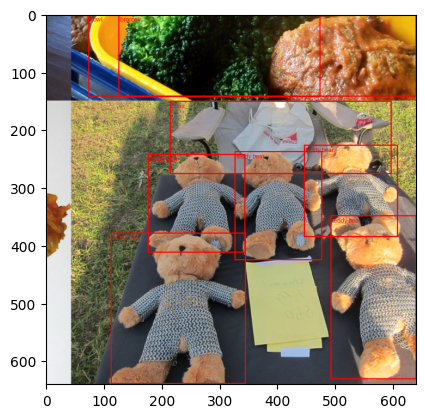

In [102]:
x, y, path, _ = dataset2[0]
print(x.shape) # 3x640x640
print(y.shape) # n_obj*6: 
show_image(x, y)

In [ ]:
stride

In [ ]:
train_loader, dataset = create_dataloader(train_path,
      imgsz,
      batch_size // WORLD_SIZE,
      gs,
      single_cls,
      hyp=hyp,
      augment=True,
      cache=cache,
      rect=rect,
      rank=LOCAL_RANK,
      workers=workers,
      image_weights=image_weights,
      quad=quad,
      prefix=colorstr('train: '),
      shuffle=True,
      seed=seed)

In [ ]:
x, y, path, _ = dataset[0]
print(x.shape) # 3x640x640
print(y.shape) # n_obj*6: 
show_image(x, y)

In [ ]:
y[0]